In [2]:
!pip install -U langchain-google-genai

  Obtaining dependency information for langchain-google-genai from https://files.pythonhosted.org/packages/59/82/2a5d3fe54df23d6471768b9558f9a73e1a712065e6c20a228aa3254092aa/langchain_google_genai-2.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for filetype<2.0.0,>=1.2.0 from https://files.pythonhosted.org/packages/18/79/1b8fa1bb3568781e84c9200f951c735f3f157429f44be0495da55894d620/filetype-1.2.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for google-ai-generativelanguage<0.7.0,>=0.6.16 from https://files.pythonhosted.org/packages/e7/ae/1c1553aea9209db84ed8c0b2f8d2dd3feb146290fdae5988b54ee71b5c9d/google_ai_generativelanguage-0.6.17-py3-none-any.whl.metadata
  Obtaining dependency information for langchain-core<0.4.0,>=0.3.49 from https://files.pythonhosted.org/packages/dd/35/27164f5f23517be8639b518130e6235293dae52c41988790e0b50dd7ba11/langchain_core-0.3.49-py3-none-any.whl.metadata
  Obtaining dependency information for google-api-core[grpc]!=2.0.


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from langchain.agents import AgentExecutor, Tool, AgentType, initialize_agent
from dotenv import load_dotenv
from langchain.memory import ConversationBufferMemory
from pydantic import BaseModel, Field
from typing import List, Dict, Any, Optional, Union
from langchain_groq import ChatGroq
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from typing import Dict, List, TypedDict, Literal
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
import os
import json
import logging
from functools import lru_cache
import time
from contextlib import contextmanager

In [4]:
# Configure logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


# Environment setup
load_dotenv()

True

In [5]:
# Cache API keys to avoid repeated lookups
API_KEYS = {
    "GROQ_API_KEY": os.getenv("GROQ_API_KEY"),
    "OPENAI_API_KEY": os.getenv("OPENAI_API_KEY"),
    "LANGCHAIN_API_KEY": os.getenv("LANGCHAIN_API_KEY"),
    "GOOGLE_API_KEY": os.getenv("GOOGLE_API_KEY")
}

In [6]:
# Set environment variables
for key, value in API_KEYS.items():
    if value:
        os.environ[key] = value

In [7]:
# Constants
MAX_ITERATIONS = 10
APPROVED_PHRASES = {
    "user_stories": "here is my approval for all user stories",
    "design_doc": "go ahead",
    "code_review": "no additional review comments",
    "security_review": "no additional security review comments",
    "test_case_review": "no additional test case review comments",
    "qa_testing": "qa testing passed"
}


In [8]:
# Performance monitoring
@contextmanager
def timer(description):
    """Context manager for timing code execution"""
    start = time.time()
    yield
    elapsed = time.time() - start
    logger.info(f"{description} took {elapsed:.2f} seconds")


In [9]:
class GraphState(TypedDict):
    """State maintained throughout the workflow graph execution"""
    user_requirement: str
    generated_user_stories: str
    po_review_comment: str
    stories_correction_iteration: int
    design_doc: str
    design_doc_review_iteration: int
    design_doc_review_comments: str
    generated_code: str
    code_review_comments: str
    code_review_iteration: int
    security_review_comments: str
    security_review_iteration: int
    generated_test_cases: str
    test_case_review_comments: str
    test_case_review_iteration: int
    qa_testing_result: str
    qa_testing_iteration: int
    deployment_plan: str
    monitoring_plan: str
    maintenance_plan: str
    messages: List[Union[HumanMessage, SystemMessage, AIMessage]]

In [10]:
@lru_cache(maxsize=16)
def get_llm(model_type, model_name=None):
    """
    Factory function to get LLM instances with caching for efficiency.

    Args:
        model_type: Type of LLM provider (groq, google, openai)
        model_name: Specific model name for the provider

    Returns:
        LLM instance
    """
    try:
        if model_type == "groq":
            if not model_name:
                model_name = "deepseek-r1-distill-qwen-32b"
            return ChatGroq(model=model_name)
        elif model_type == "google":
            return ChatGoogleGenerativeAI(
                model=model_name or "gemini-2.0-flash",
                temperature=0,
                max_tokens=None,
                timeout=None
            )
        elif model_type == "openai":
            return ChatOpenAI(model_name=model_name or "gpt-4")
        else:
            raise ValueError(f"Unsupported model type: {model_type}")
    except Exception as e:
        logger.error(f"Error initializing LLM {model_type}/{model_name}: {e}")
        # Default to a fallback model
        return ChatGroq(model="deepseek-r1-distill-qwen-32b")


In [11]:
def read_file(filename, default=""):
    """Safely read file content"""
    try:
        with open(filename) as f:
            return f.read()
    except Exception as e:
        logger.error(f"Error reading file {filename}: {e}")
        return default

In [12]:
def extract_content_after_pattern(text):
    """Extract content after a specific pattern"""
    pattern = "\n</think>\n\n"
    position = text.find(pattern)

    if position == -1:
        return text  # Pattern not found, return original text

    start_position = position + len(pattern)
    return text[start_position:]

In [13]:
def get_user_requirements_node(state: GraphState) -> GraphState:
    """Node that retrieves user requirements from file"""

    logger.info("Getting user requirements...")

    with timer("Reading requirements file"):
        user_requirements = read_file("req_build.md", "No requirements found")

    return {"user_requirement": user_requirements}

In [14]:
def generate_user_stories_node(state: GraphState) -> GraphState:
    """Node that generates user stories based on requirements"""

    current_state = state
    user_requirements = current_state['user_requirement']
    po_review_comment = current_state.get('po_review_comment', '')
    stories_correction_iteration = current_state.get(
        'stories_correction_iteration', 0)

    logger.info(
        f"Generating user stories (iteration {stories_correction_iteration + 1})...")

    messages = [
        SystemMessage(content="You are an expert Product Manager. Your job is to create well-structured user stories for the given requirement for the developers to implement and return the response as Python list. If feedback is provided, modify the stories based on the feedback."),
        HumanMessage(
            content=f"Generate list of user stories for requirement {user_requirements} or if feedbacks are provided on user stories in {po_review_comment}, modify them based on the feedbacks. Each user story should have a title, description, acceptance criteria, priority and status")
    ]

    with timer("User stories generation"):
        llm = get_llm("groq", "deepseek-r1-distill-llama-70b")
        response = llm.invoke(messages)
        user_stories = response.content.strip()
        user_stories = extract_content_after_pattern(user_stories)

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as Product Manager. Here are the Generated User Stories: {user_stories}")
    ]

    return {
        "user_requirement": state["user_requirement"],
        "generated_user_stories": user_stories,
        "stories_correction_iteration": stories_correction_iteration + 1,
        "po_review_comment": current_state.get("po_review_comment", ""),
        "design_doc_review_iteration": current_state.get("design_doc_review_iteration", 0),
        "design_doc": current_state.get("design_doc", ""),
        "design_doc_review_comments": current_state.get("design_doc_review_comments", ""),
        "messages": new_messages
    }

In [15]:
def po_review_stories_node(state: GraphState) -> GraphState:
    """Node for product owner to review user stories"""

    user_requirements = state["user_requirement"]
    user_stories = state["generated_user_stories"]

    logger.info("PO is reviewing user stories...")

    messages = [
        SystemMessage(content="You are a Product Owner. Your job is to provide feedback on User Stories against the given requirement and either approve it or provide feedback. The goal is to build MVP first i.e build product fast and then iterate on it."),
        HumanMessage(content=f"Review the List of User Stories {user_stories} against requirement {user_requirements}. If you approve of all the user stories then mention 'Here is my approval for all user stories' in your review comments else provide feedback on the user stories with the changes required and start your comments with 'Here are the changes required' and don't mention word 'approved' anywhere in your comments.")
    ]

    with timer("PO review"):
        llm = get_llm("groq", "deepseek-r1-distill-qwen-32b")
        response = llm.invoke(messages)
        po_review_comment = response.content.strip()
        po_review_comment = extract_content_after_pattern(po_review_comment)

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as Product owner.Here is the Generated Product owner Review comment for user stories: {po_review_comment}")
    ]

    return {
        **state,
        "po_review_comment": po_review_comment,
        "messages": new_messages
    }

In [16]:
def create_design_doc_node(state: GraphState) -> GraphState:
    """Node to create functional and technical design documents"""

    user_requirements = state["user_requirement"]
    user_stories = state["generated_user_stories"]
    design_doc_review_iteration = state.get("design_doc_review_iteration", 0)
    design_doc_review_comments = state.get("design_doc_review_comments", "")

    logger.info(
        f"Generating design documents (iteration {design_doc_review_iteration + 1})...")

    messages = [
        SystemMessage(content="You are a Software Architect with strong business analysis skills. Your job is to create comprehensive Functional and Technical design documents of great quality against given requirement and user stories."),
        HumanMessage(
            content=f"Create Functional and Technical design documents based on {user_stories} against requirement {user_requirements}. If feedback is present in {design_doc_review_comments} modify the document accordingly. The goal is to build MVP first i.e build product fast and then iterate on it. Return document in markdown format.")
    ]

    with timer("Design document creation"):
        llm = get_llm("google", "gemini-2.0-flash")
        response = llm.invoke(messages)
        design_doc = response.content.strip()

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as Software Architect and creating Functional and Technical design doc.Here is the generated functional and technical design doc: {design_doc}")
    ]

    return {
        **state,
        "design_doc": design_doc,
        "design_doc_review_iteration": design_doc_review_iteration + 1,
        "messages": new_messages
    }


In [17]:
def design_doc_review_node(state: GraphState) -> GraphState:
    """Node for reviewing design documents"""

    user_requirements = state["user_requirement"]
    user_stories = state["generated_user_stories"]
    design_doc = state["design_doc"]

    logger.info("Reviewing design documents...")

    messages = [
        SystemMessage(content="You are a Software Architect. Your job is to review Functional and Technical design documents against given requirement and user stories. Don't nitpick and be liberal while providing feedback."),
        HumanMessage(content=f"Review the Functional and Technical design documents {design_doc} based on {user_stories} and requirement {user_requirements}. If you are happy with the documents, mention 'Go ahead, Here is my approval for the design documents' or else provide feedback on the documents and start your comments with 'Here are the changes required' and don't mention word 'approved' anywhere in your comments.")
    ]

    with timer("Design document review"):
        llm = get_llm("google", "gemini-2.0-flash")
        response = llm.invoke(messages)
        design_doc_review_comments = response.content.strip()

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as Software Architect and reviewing Functional and Technical design doc.Here is the generated Functional and technical design doc review comments: {design_doc_review_comments}")
    ]

    return {
        **state,
        "design_doc_review_comments": design_doc_review_comments,
        "messages": new_messages
    }


In [18]:
def coder_node(state: GraphState) -> GraphState:
    """Node that generates code based on requirements and design"""

    user_requirements = state["user_requirement"]
    user_stories = state["generated_user_stories"]
    design_doc = state["design_doc"]
    code_review_comments = state.get("code_review_comments", "")
    security_review_comments = state.get("security_review_comments", "")
    code_review_iteration = state.get("code_review_iteration", 0)
    qa_testing_result = state.get("qa_testing_result", "")

    logger.info(f"Generating code (iteration {code_review_iteration + 1})...")

    messages = [
        SystemMessage(content="You are an expert python coder. Your job is to create python code for the given requirement, user stories and design document that will accurately implement the functionality. If peer review comments or security review feedbacks are provided, implement those changes to code accordingly."),
        HumanMessage(
            content=f"Generate the python code as per the requirement: {user_requirements}, user stories: {user_stories}, Functional and Technical Design: {design_doc}. If peer comments are provided in {code_review_comments} or security review aspect of code is present in {security_review_comments}, implement those changes too in the code.If QA testing is failed as per {qa_testing_result} fix the code.")
    ]

    with timer("Code generation"):
        llm = get_llm("google", "gemini-2.0-flash")
        response = llm.invoke(messages)
        generated_code = response.content.strip()

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as python coder and generating code. Here is the Generated Code: {generated_code}")
    ]

    return {
        **state,
        "generated_code": generated_code,
        "code_review_iteration": code_review_iteration + 1,
        "messages": new_messages
    }


In [19]:
def code_reviewer_node(state: GraphState) -> GraphState:
    """Node for reviewing generated code"""

    user_requirements = state["user_requirement"]
    user_stories = state["generated_user_stories"]
    design_doc = state["design_doc"]
    generated_code = state["generated_code"]

    logger.info("Reviewing code...")

    messages = [
        SystemMessage(content="You are a code reviewer. Your job is to review the code against the given requirement, stories and design doc and check if it implements all the functionalities and covers all scenarios. Return 'no additional review comments' if you find the code is good enough."),
        HumanMessage(content=f"Peer review the code {generated_code} against the requirement: {user_requirements}, user stories: {user_stories}, Functional and Technical Design: {design_doc} and provide your review comments on the code. Don't nitpick while providing your review comments. Return 'no additional review comments' if you find the code is good enough.")
    ]

    with timer("Code review"):
        llm = get_llm("google", "gemini-2.0-flash")
        response = llm.invoke(messages)
        code_review_comments = response.content.strip()

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as code reviewer.Here is the Generated code review comments: {code_review_comments}")
    ]

    return {
        **state,
        "code_review_comments": code_review_comments,
        "messages": new_messages
    }


In [20]:
def security_review_node(state: GraphState) -> GraphState:
    """Node for security review of code"""

    user_requirements = state["user_requirement"]
    user_stories = state["generated_user_stories"]
    design_doc = state["design_doc"]
    generated_code = state["generated_code"]
    security_review_iteration = state.get("security_review_iteration", 0)

    logger.info(
        f"Performing security review (iteration {security_review_iteration + 1})...")

    messages = [
        SystemMessage(content="You are a Software Security Engineer. Your job is to review the security aspects of code against the given requirement, stories and design doc and provide security review feedback. Return 'no additional security review comments' if you find the code is good enough regarding security."),
        HumanMessage(content=f"Do the security review of the code {generated_code} against the requirement: {user_requirements}, user stories: {user_stories}, Functional and Technical Design: {design_doc} and provide your feedback on the code regarding security. Don't nitpick while providing your feedback. Return 'no additional security review comments' if you find the code is good enough.")
    ]

    with timer("Security review"):
        llm = get_llm("google", "gemini-2.0-flash")
        response = llm.invoke(messages)
        security_review_comments = response.content.strip()

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as Security Engineer and performing security review.Here is the Generated security review comments: {security_review_comments}")
    ]

    return {
        **state,
        "security_review_comments": security_review_comments,
        "security_review_iteration": security_review_iteration + 1,
        "messages": new_messages
    }



In [21]:
def write_test_cases_node(state: GraphState) -> GraphState:
    """Node for writing test cases"""

    user_requirements = state["user_requirement"]
    user_stories = state["generated_user_stories"]
    design_doc = state["design_doc"]
    security_review_comments = state.get("security_review_comments", "")
    test_case_review_comments = state.get("test_case_review_comments", "")
    test_case_review_iteration = state.get("test_case_review_iteration", 0)

    logger.info(
        f"Generating test cases (iteration {test_case_review_iteration + 1})...")

    messages = [
        SystemMessage(content="You are a Software Development Engineer in Test (SDET). Your job is to write test cases against the given requirement, stories, design doc and security review comments."),
        HumanMessage(
            content=f"Write test cases against the requirement: {user_requirements}, user stories: {user_stories}, Functional and Technical Design: {design_doc}, Security Review comments: {security_review_comments}. If you find feedback in {test_case_review_comments}, modify test cases accordingly.")
    ]

    with timer("Test case generation"):
        llm = get_llm("google", "gemini-2.0-flash")
        response = llm.invoke(messages)
        generated_test_cases = response.content.strip()

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as Software Development Engineer in Test (SDET) and creating test cases. Here are the generated test cases: {generated_test_cases}")
    ]

    return {
        **state,
        "generated_test_cases": generated_test_cases,
        "test_case_review_iteration": test_case_review_iteration + 1,
        "messages": new_messages
    }


In [22]:
def test_case_review_node(state: GraphState) -> GraphState:
    """Node for reviewing test cases"""

    user_requirements = state["user_requirement"]
    user_stories = state["generated_user_stories"]
    design_doc = state["design_doc"]
    generated_test_cases = state["generated_test_cases"]
    security_review_comments = state.get("security_review_comments", "")

    logger.info("Reviewing test cases...")

    messages = [
        SystemMessage(content="You are a QA Lead/Manager. Your job is to review test cases against the given requirement, stories, design doc and security review comments and provide feedback. Return 'no additional test case review comments' if you find the test cases coverage are good enough."),
        HumanMessage(content=f"Review test cases: {generated_test_cases} against the requirement: {user_requirements}, user stories: {user_stories}, Functional and Technical Design: {design_doc}, Security Review comments: {security_review_comments} and provide feedback. Don't nitpick while providing your feedback. Return 'no additional test case review comments' if you find the test cases coverage are good enough.")
    ]

    with timer("Test case review"):
        llm = get_llm("google", "gemini-2.0-flash")
        response = llm.invoke(messages)
        test_case_review_comments = response.content.strip()

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as QA Lead/Manager and reviewing test cases. Here are the test case review comments: {test_case_review_comments}")
    ]

    return {
        **state,
        "test_case_review_comments": test_case_review_comments,
        "messages": new_messages
    }


In [23]:
def qa_testing_node(state: GraphState) -> GraphState:
    """Node for QA testing based on test cases and code"""

    user_requirements = state["user_requirement"]
    generated_code = state["generated_code"]
    generated_test_cases = state["generated_test_cases"]
    qa_testing_iteration = state["qa_testing_iteration"]

    logger.info(
        f"Running QA testing (iteration {qa_testing_iteration + 1} )...")

    messages = [
        SystemMessage(content="You are a QA Engineer. Your job is to execute the test cases against the code and determine if it passes all tests. Evaluate thoroughly if the code successfully implements all the required functionality."),
        HumanMessage(content=f"Execute the test cases: {generated_test_cases} against the code: {generated_code} and requirement: {user_requirements}. If all tests pass or have only minor issues, respond with 'QA Testing Passed' at the beginning of your analysis. If there are significant issues that need fixing, respond with 'QA Testing Failed' at the beginning and list the specific issues that need to be addressed.")
    ]

    with timer("QA testing"):
        llm = get_llm("google", "gemini-2.0-flash")
        response = llm.invoke(messages)
        qa_testing_result = response.content.strip()

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as QA Engineer and executing test cases. Here are the QA Testing Results: {qa_testing_result}")
    ]

    return {
        **state,
        "qa_testing_result": qa_testing_result,
        "messages": new_messages
    }


In [24]:
def deployment_node(state: GraphState) -> GraphState:
    """Node for creating deployment plan"""

    user_requirements = state["user_requirement"]
    generated_code = state["generated_code"]

    logger.info("Preparing deployment plan...")

    messages = [
        SystemMessage(content="You are a DevOps Engineer. Your job is to create a deployment plan for the code including any necessary infrastructure configuration, environment setup, and monitoring configuration."),
        HumanMessage(
            content=f"Create a deployment plan for the following code:\n\nCode: {generated_code}\n\nRequirement: {user_requirements}\n\nInclude details on environment setup, configuration files, deployment steps, and any monitoring that should be set up.")
    ]

    with timer("Deployment planning"):
        llm = get_llm("google", "gemini-2.0-flash")
        response = llm.invoke(messages)
        deployment_plan = response.content.strip()

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as DevOps Engineer and creating deployment plan. Here is the Deployment Plan: {deployment_plan}")
    ]

    return {
        **state,
        "deployment_plan": deployment_plan,
        "messages": new_messages
    }


In [25]:
def monitoring_feedback_node(state: GraphState) -> GraphState:
    """Node for setting up monitoring and feedback collection"""

    user_requirements = state["user_requirement"]
    generated_code = state["generated_code"]
    deployment_plan = state["deployment_plan"]

    logger.info("Setting up monitoring and feedback collection...")

    messages = [
        SystemMessage(content="You are a Site Reliability Engineer (SRE). Your job is to design monitoring systems and feedback collection mechanisms for the deployed application."),
        HumanMessage(
            content=f"Design monitoring systems and feedback collection for:\n\nCode: {generated_code}\n\nDeployment Plan: {deployment_plan}\n\nRequirement: {user_requirements}\n\nInclude details on metrics to track, alerting thresholds, logging strategies, and user feedback collection methods.")
    ]

    with timer("Monitoring setup"):
        llm = get_llm("google", "gemini-2.0-flash")
        response = llm.invoke(messages)
        monitoring_plan = response.content.strip()

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as Site Reliability Engineer (SRE) and creating Design monitoring systems. Here is the Monitoring and Feedback Plan: {monitoring_plan}")
    ]

    return {
        **state,
        "monitoring_plan": monitoring_plan,
        "messages": new_messages
    }


In [26]:
def maintenance_updates_node(state: GraphState) -> GraphState:
    """Node for creating maintenance and updates plan"""

    user_requirements = state["user_requirement"]
    generated_code = state["generated_code"]
    monitoring_plan = state.get("monitoring_plan", "")

    logger.info("Creating maintenance and updates plan...")

    messages = [
        SystemMessage(content="You are a Software Maintenance Engineer. Your job is to create a maintenance plan for the application including update strategies, technical debt management, and future enhancement roadmap."),
        HumanMessage(
            content=f"Create a maintenance and updates plan for:\n\nCode: {generated_code}\n\nRequirement: {user_requirements}\n\nMonitoring Plan: {monitoring_plan}\n\nInclude strategies for updates, dependency management, performance optimization, and potential future enhancements.")
    ]

    with timer("Maintenance planning"):
        llm = get_llm("google", "gemini-2.0-flash")
        response = llm.invoke(messages)
        maintenance_plan = response.content.strip()

    # Update state
    new_messages = state.get("messages", []) + messages + [
        AIMessage(
            content=f"AI is now acting as Software Maintenance Engineer and creating Maintenance and Updates Plan:,Her it is {maintenance_plan}")
    ]

    return {
        **state,
        "maintenance_plan": maintenance_plan,
        "messages": new_messages
    }


In [ ]:
def build_workflow_graph():
    """Build and return the workflow graph"""

    builder = StateGraph(GraphState)

    # Add nodes
    builder.add_node("get_user_requirements", get_user_requirements_node)
    builder.add_node("generate_user_stories", generate_user_stories_node)
    builder.add_node("po_review_stories", po_review_stories_node)
    builder.add_node("create_design_doc", create_design_doc_node)
    builder.add_node("design_doc_review", design_doc_review_node)
    builder.add_node("coder", coder_node)
    builder.add_node("code_reviewer", code_reviewer_node)
    builder.add_node("security_review", security_review_node)
    builder.add_node("write_test_cases", write_test_cases_node)
    builder.add_node("test_case_review", test_case_review_node)
    builder.add_node("qa_testing", qa_testing_node)
    # builder.add_node("fix_code_after_qa", fix_code_after_qa_node)
    builder.add_node("deployment", deployment_node)
    builder.add_node("monitoring_feedback", monitoring_feedback_node)
    builder.add_node("maintenance_updates", maintenance_updates_node)

    # Define conditional edge functions
    def review_condition_stories(state):
        logger.info(
            f"Stories correction iteration: {state.get('stories_correction_iteration', 0)}")
        if APPROVED_PHRASES["user_stories"] in state.get('po_review_comment', '').lower():
            logger.info("User stories approved")
            return "create_design_doc"
        elif state.get('stories_correction_iteration', 0) < MAX_ITERATIONS:
            return "generate_user_stories"
        else:
            logger.warning("Max story iterations reached, proceeding anyway")
            return "create_design_doc"

    def review_condition_design_doc(state):
        logger.info(
            f"Design doc review count: {state.get('design_doc_review_iteration', 0)}")
        if APPROVED_PHRASES["design_doc"] in state.get("design_doc_review_comments", "").lower():
            logger.info("Design document approved")
            return "coder"
        elif state.get('design_doc_review_iteration', 0) < MAX_ITERATIONS:
            return "create_design_doc"
        else:
            logger.warning(
                "Max design doc iterations reached, proceeding anyway")
            return "coder"

    def review_condition_code_review(state):
        logger.info(
            f"Code review iteration: {state.get('code_review_iteration', 0)}")
        if APPROVED_PHRASES["code_review"] in state.get("code_review_comments", "").lower():
            logger.info("Code review passed")
            return "security_review"
        elif state.get('code_review_iteration', 0) < MAX_ITERATIONS:
            return "coder"
        else:
            logger.warning(
                "Max code review iterations reached, proceeding anyway")
            return "security_review"

    def review_condition_security_review(state):
        logger.info(
            f"Security review iteration: {state.get('security_review_iteration', 0)}")
        if APPROVED_PHRASES["security_review"] in state.get("security_review_comments", "").lower():
            logger.info("Security review passed")
            return "write_test_cases"
        elif state.get('security_review_iteration', 0) < MAX_ITERATIONS:
            return "coder"
        else:
            logger.warning(
                "Max security review iterations reached, proceeding anyway")
            return "write_test_cases"

    def review_condition_testcase_review(state):
        logger.info(
            f"Test case review iteration: {state.get('test_case_review_iteration', 0)}")
        if APPROVED_PHRASES["test_case_review"] in state.get("test_case_review_comments", "").lower():
            logger.info("Test cases review passed")
            return "qa_testing"
        elif state.get('test_case_review_iteration', 0) < MAX_ITERATIONS:
            return "write_test_cases"
        else:
            logger.warning(
                "Max test case review iterations reached, proceeding anyway")
            return "qa_testing"

    def qa_testing_condition(state):
        logger.info(
            f"QA Testing iteration: {state.get('qa_testing_iteration', 0)}")
        if APPROVED_PHRASES["qa_testing"] in state.get("qa_testing_result", "").lower():
            logger.info("QA Testing Passed")
            return "deployment"
        else:
            print("QA Testing Failed")
            return "coder"

    # Define the edges
    builder.add_edge(START, "get_user_requirements")
    # After getting requirements, generate user stories
    builder.add_edge("get_user_requirements", "generate_user_stories")
    # After Generating User Stories Product owner reviews user stories
    builder.add_edge("generate_user_stories", "po_review_stories")
    # Conditional edge for PO review.If Approved create design doc else revise stories
    builder.add_conditional_edges(
        "po_review_stories",
        review_condition_stories
    )
    # After design document creation, review of design doc
    builder.add_edge("create_design_doc", "design_doc_review")
    # Conditional edge for Design doc review.If Approved proceed to coding else revise design doc
    builder.add_conditional_edges(
        "design_doc_review",
        review_condition_design_doc
    )
    # After coding, peer review of code
    builder.add_edge("coder", "code_reviewer")
    # Conditional edge for Code review.If approved proceed to security review else revise code
    builder.add_conditional_edges(
        "code_reviewer",
        review_condition_code_review
    )
    # Conditional edge for security review.If approved proceed to test case creation else revise code
    builder.add_conditional_edges(
        "security_review",
        review_condition_security_review
    )
    # After test case creation, test case review
    builder.add_edge("write_test_cases", "test_case_review")
    # Conditional edge for test case review. If approved proceed to qa testing else revise test cases
    builder.add_conditional_edges(
        "test_case_review",
        review_condition_testcase_review
    )
    # Conditional edge for QA testing. If passed proceed to deployment else revise code
    builder.add_conditional_edges(
        "qa_testing",
        qa_testing_condition
    )
    # builder.add_edge("fix_code_after_qa", "qa_testing")
    builder.add_edge("deployment", "monitoring_feedback")
    builder.add_edge("monitoring_feedback", "maintenance_updates")
    builder.add_edge("maintenance_updates", END)

    # Build the graph
    react_graph = builder.compile()
    # Show
    display(Image(react_graph.get_graph().draw_mermaid_png()))

    return react_graph


In [28]:
def run_workflow() -> Dict:
    """
    Run the workflow for given requirement.

    Args:
        Requirement: The functionality that needs to be implemented

    Returns:
        Dict containing the generated code, review comment and doc string
    """
    # Initialize state
    initial_state = {
        "user_requirement": "",
        "generated_user_stories": "",
        "po_review_comment": "",
        "stories_correction_iteration": 0,
        'design_doc_review_iteration': 0,
        'design_doc': "",
        "design_doc_review_comments": "",
        "generated_code": "",
        "code_review_comments": "",
        "code_review_iteration": 0,
        "security_review_comments": "",
        "security_review_iteration": 0,
        "generated_test_cases": "",
        "test_case_review_comments": "",
        "test_case_review_iteration": 0,
        "qa_testing_result": "",
        "qa_testing_iteration": 0,
        "deployment_plan": "",
        "monitoring_plan": "",
        "maintenance_plan": "",
        "messages": [HumanMessage(content=f"Getting requirements from file")]
    }

    # Run the graph
    graph = build_workflow_graph()
    result = graph.invoke(initial_state, {"recursion_limit": 100})

    return {
        "user_requirement": result["user_requirement"],
        "generated_user_stories": result["generated_user_stories"],
        "po_review_comment": result["po_review_comment"],
        "stories_correction_iteration": result["stories_correction_iteration"],
        "design_doc_review_iteration": result["design_doc_review_iteration"],
        'design_doc': result["design_doc"],
        "design_doc_review_comments": result["design_doc_review_comments"],
        "generated_code": result["generated_code"],
        "code_review_comments": result["code_review_comments"],
        "code_review_iteration": result["code_review_iteration"],
        "security_review_comments": result["security_review_comments"],
        "security_review_iteration": result["security_review_iteration"],
        "generated_test_cases": result["generated_test_cases"],
        "test_case_review_comments": result["test_case_review_comments"],
        "test_case_review_iteration": result["test_case_review_iteration"],
        "qa_testing_result": result["qa_testing_result"],
        "qa_testing_iteration": result["qa_testing_iteration"],
        "deployment_plan": result["deployment_plan"],
        "monitoring_plan": result["monitoring_plan"],
        "maintenance_plan": result["maintenance_plan"],
        "messages": result["messages"]
    }


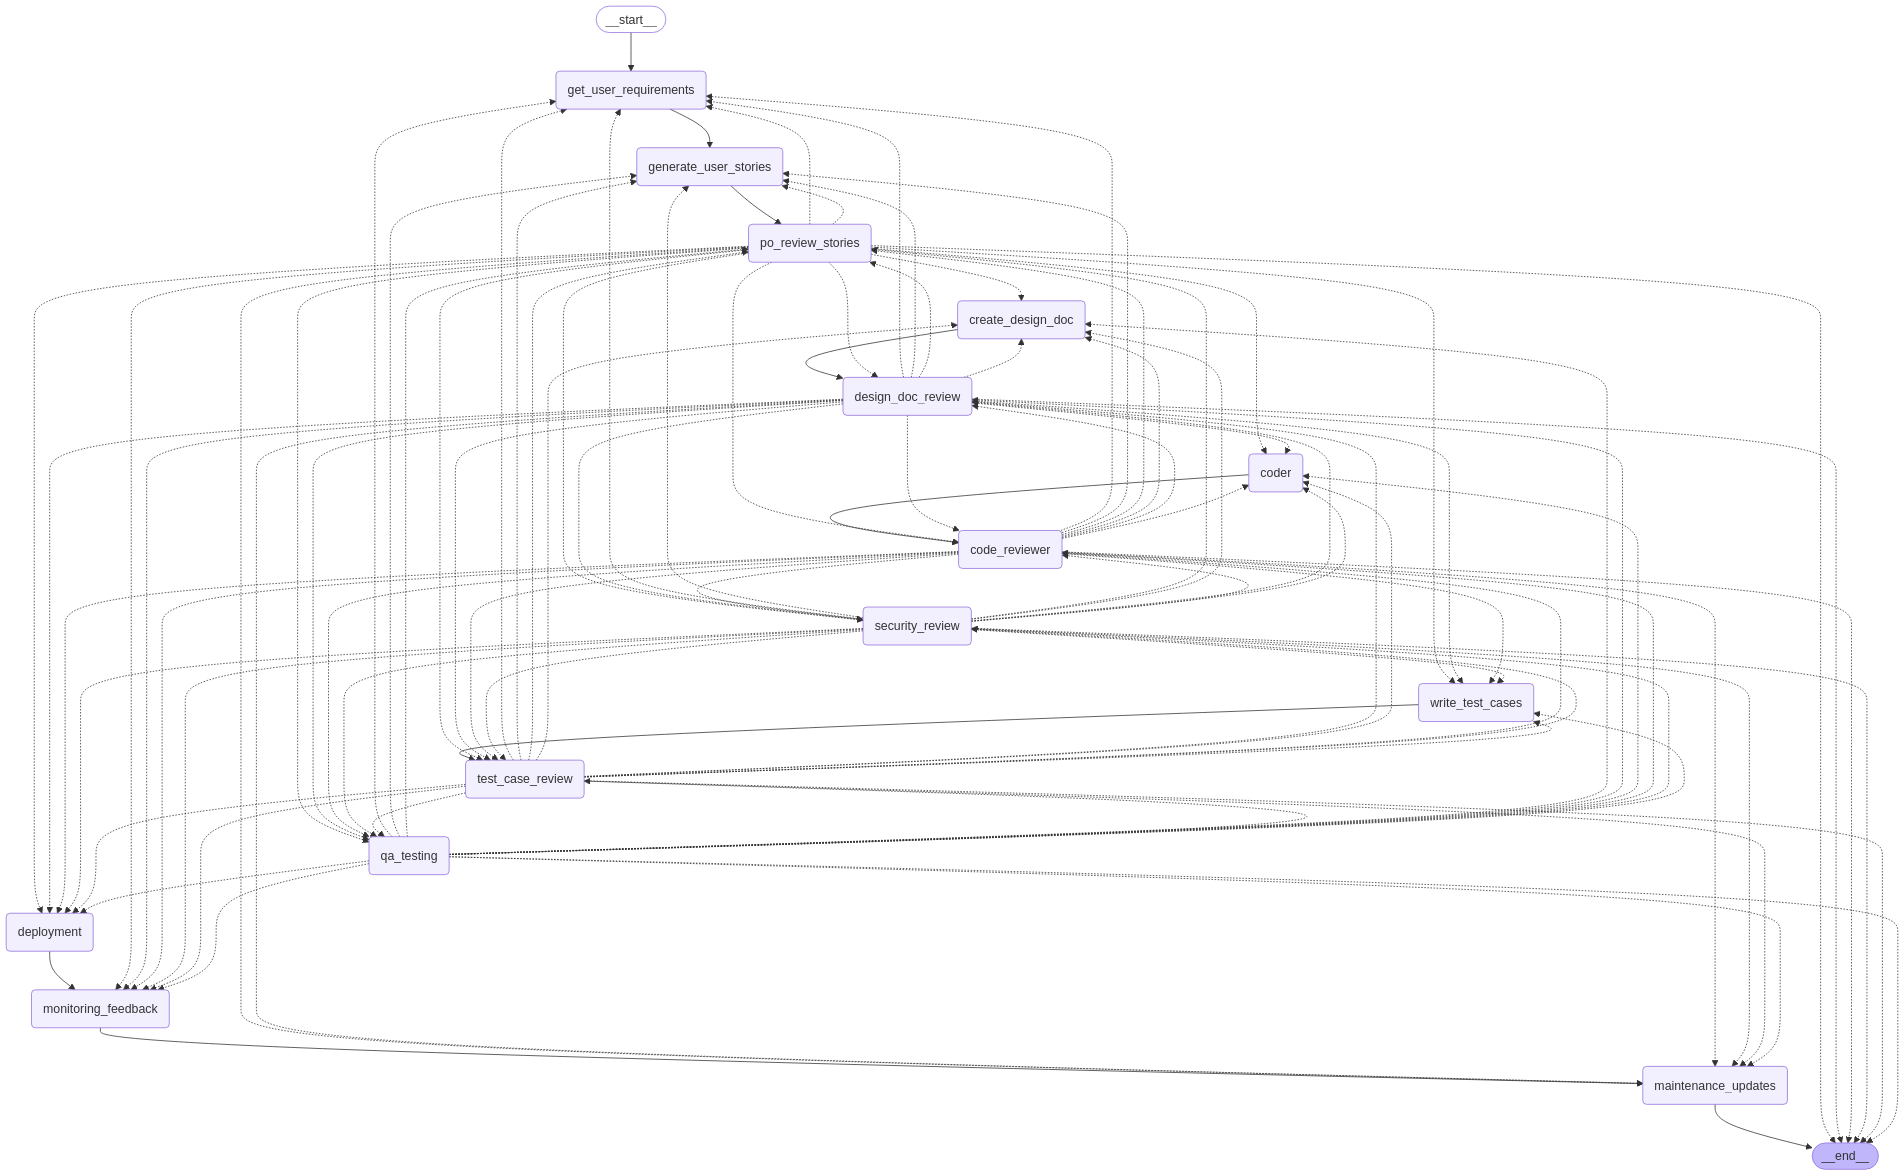

2025-03-28 20:40:14,271 - __main__ - INFO - Getting user requirements...
2025-03-28 20:40:14,393 - __main__ - INFO - Reading requirements file took 0.04 seconds
2025-03-28 20:40:14,401 - __main__ - INFO - Generating user stories (iteration 1)...
2025-03-28 20:40:23,786 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-28 20:40:23,818 - __main__ - INFO - User stories generation took 9.42 seconds
2025-03-28 20:40:23,823 - __main__ - INFO - PO is reviewing user stories...
2025-03-28 20:40:35,268 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-28 20:40:35,279 - __main__ - INFO - PO review took 11.45 seconds
2025-03-28 20:40:35,284 - __main__ - INFO - Stories correction iteration: 1
2025-03-28 20:40:35,293 - __main__ - INFO - Generating user stories (iteration 2)...
2025-03-28 20:40:41,307 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completion

QA Testing Passed


2025-03-28 20:42:19,039 - __main__ - INFO - Deployment planning took 13.74 seconds
2025-03-28 20:42:19,043 - __main__ - INFO - Setting up monitoring and feedback collection...
2025-03-28 20:42:36,638 - __main__ - INFO - Monitoring setup took 17.59 seconds
2025-03-28 20:42:36,651 - __main__ - INFO - Creating maintenance and updates plan...
2025-03-28 20:42:51,433 - __main__ - INFO - Maintenance planning took 14.78 seconds


{'user_requirement': 'Build Web app Snake and Ladder Game using Python and Flask', 'generated_user_stories': "Here is a list of user stories for the Snake and Ladder game, organized based on the feedback and prioritization provided. Each user story includes a title, description, acceptance criteria, priority, and status.\n\n### User Stories for Snake and Ladder Game\n\n---\n\n#### **1. Create Game Board**\n- **Title:** Create Game Board\n- **Description:** The game board should be a grid representing the playing field where tokens move.\n- **Acceptance Criteria:**\n  - The board should have 100 squares.\n  - The board should be visually represented in the web app.\n  - The board should include numbered squares from 1 to 100.\n- **Priority:** High\n- **Status:** Ready for Development\n\n---\n\n#### **2. Implement Player Tokens**\n- **Title:** Implement Player Tokens\n- **Description:** Players should have tokens to represent their position on the board.\n- **Acceptance Criteria:**\n  - 

In [ ]:
result = run_workflow()


In [30]:
print(result)

{'user_requirement': 'Build Web app Snake and Ladder Game using Python and Flask', 'generated_user_stories': "Here is a list of user stories for the Snake and Ladder game, organized based on the feedback and prioritization provided. Each user story includes a title, description, acceptance criteria, priority, and status.\n\n### User Stories for Snake and Ladder Game\n\n---\n\n#### **1. Create Game Board**\n- **Title:** Create Game Board\n- **Description:** The game board should be a grid representing the playing field where tokens move.\n- **Acceptance Criteria:**\n  - The board should have 100 squares.\n  - The board should be visually represented in the web app.\n  - The board should include numbered squares from 1 to 100.\n- **Priority:** High\n- **Status:** Ready for Development\n\n---\n\n#### **2. Implement Player Tokens**\n- **Title:** Implement Player Tokens\n- **Description:** Players should have tokens to represent their position on the board.\n- **Acceptance Criteria:**\n  - 